In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
print("TensorFlow version:", tf.__version__)
# Set a random seed for reproducible results 
tf.random.set_seed(22)

#本快速入门教程演示了如何使用 TensorFlow Core 低级 API 来构建和训练预测燃油效率的多元线性回归模型。
#它使用 Auto MPG 数据集，其中包含 20 世纪 70 年代末和 20 世纪 80 年代初汽车的燃油效率数据。

#您将遵循机器学习过程的典型阶段：
#   加载数据集。
#   构建输入流水线。
#   构建多元线性回归模型。
#   评估模型的性能。



TensorFlow version: 2.15.0


In [2]:
### 3.1.1 加载和预处理数据集
#该数据集使用气缸、排量、马力和重量等各种定量和分类特征来预测 20 世纪 70 年代末和 20 世纪 80 年代初汽车的燃油效率。
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = dataset.dropna() # 去除任何缺失值
dataset_tf = tf.convert_to_tensor(dataset, dtype=tf.float32) #将数据集转换为 tf.float32 张量类型。
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [3]:
#接下来，将数据集拆分为训练集和测试集。确保使用 tf.random.shuffle 重排数据集，以避免有偏差的拆分。
dataset_shuffled = tf.random.shuffle(dataset_tf, seed=22)
train_data, test_data = dataset_shuffled[100:], dataset_shuffled[:100]
x_train, y_train = train_data[:, 1:], train_data[:, 0]
x_test, y_test = test_data[:, 1:], test_data[:, 0]



In [4]:
#dataset_shuffled = tf.random.shuffle(dataset_tf, seed=22)
def onehot_origin(x):
  origin = tf.cast(x[:, -1], tf.int32)
  # Use `origin - 1` to account for 1-indexed feature
  origin_oh = tf.one_hot(origin - 1, 3)
  x_ohe = tf.concat([x[:, :-1], origin_oh], axis = 1)
  return x_ohe

x_train_ohe, x_test_ohe = onehot_origin(x_train), onehot_origin(x_test)
x_train_ohe.numpy()

array([[  4., 140.,  72., ...,   1.,   0.,   0.],
       [  4., 120.,  74., ...,   0.,   0.,   1.],
       [  4., 122.,  88., ...,   0.,   1.,   0.],
       ...,
       [  8., 318., 150., ...,   1.,   0.,   0.],
       [  4., 156., 105., ...,   1.,   0.,   0.],
       [  6., 232., 100., ...,   1.,   0.,   0.]], dtype=float32)

In [5]:
#此示例显示了一个多元回归问题，其中预测器或特征具有截然不同的尺度。因此，标准化数据以使每个特征具有零均值和单位方差会有所帮助。
#使用 tf.reduce_mean 和 tf.math.reduce_std 函数进行标准化。然后，可以对回归模型的预测进行非标准化以获得其用原始单位表示的值。
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.math.reduce_mean(x, axis=0)
    self.std = tf.math.reduce_std(x, axis=0)

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

In [6]:
norm_x = Normalize(x_train_ohe)
norm_y = Normalize(y_train)
x_train_norm, y_train_norm = norm_x.norm(x_train_ohe), norm_y.norm(y_train)
x_test_norm, y_test_norm = norm_x.norm(x_test_ohe), norm_y.norm(y_test)

In [21]:
### 3.1.2 构建机器学习模型
#通过使用 @tf.function 装饰器，跟踪相应的 Python 代码以生成可调用的 TensorFlow 计算图。
#这种方式有利于在训练后保存和加载模型。它还可以为具有多层和复杂运算的模型带来性能提升。

#即定义y = f(x)
class LinearRegression(tf.Module):
    def __init__(self):
        self.built = False

    @tf.function
    def __call__(self, x):
        # Initialize the model parameters on the first call
        if not self.built:
            rand_w = tf.random.uniform(shape=[x.shape[-1],1])
            rand_b = tf.random.uniform(shape=[])
            self.w = tf.Variable(rand_w)
            self.b = tf.Variable(rand_b)
            self.built = True

        y = tf.add(tf.matmul(x, self.w), self.b)
        return tf.squeeze(y, axis=1)    


In [22]:
#对于每个样本，该模型通过计算其特征的加权和加上一个偏差项来返回对输入汽车 MPG 的预测值。
#然后，可以对该预测值进行非标准化以获得其用原始单位表示的值。
lin_reg = LinearRegression()
prediction = lin_reg(x_train_norm[:1])
prediction_unnorm = norm_y.unnorm(prediction)
prediction_unnorm.numpy()

array([6.8007336], dtype=float32)

In [27]:
### 3.1.3 定义损失函数
#mse
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))    

In [24]:
### 3.1.4 训练并评估模型
#使用 mini-batch 进行训练既可以提高内存效率，又能加快收敛速度​​。
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train_norm))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test_norm))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)


In [28]:
#接下来，编写一个训练循环，通过使用 MSE 损失函数及其相对于输入参数的梯度来迭代更新模型的参数。

## 主要是用sgd等优化loss

# Set training parameters
epochs = 100
learning_rate = 0.01
train_losses, test_losses = [], []

## Format training loop
for epoch in range(epochs):
    batch_losses_train, batch_losses_test = [], []

    # Iterate through the training data
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred_batch = lin_reg(x_batch)
            batch_loss = mse_loss(y_pred_batch, y_batch)

        # Update parameters with respect to the gradient calculations
        grads = tape.gradient(batch_loss, lin_reg.variables)
        for g,v in zip(grads, lin_reg.variables):
            v.assign_sub(learning_rate * g)

        # Keep track of batch-level training performance
        batch_losses_train.append(batch_loss)

    # Iterate through the testing data
    for x_batch, y_batch in test_dataset:
        y_pred_batch = lin_reg(x_batch)
        batch_loss = mse_loss(y_pred_batch, y_batch)
        batch_losses_test.append(batch_loss)

    # Keep track of epoch-level model performance
    train_loss = tf.reduce_mean(batch_losses_train)
    test_loss = tf.reduce_mean(batch_losses_test)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if epoch % 10 == 0:
        print(f'Mean squared error for step {epoch}: {train_loss.numpy():0.3f}')

# Output final losses
print(f"\nFinal train loss: {train_loss:0.3f}")
print(f"Final test loss: {test_loss:0.3f}")    


Mean squared error for step 0: 2.858
Mean squared error for step 10: 0.468
Mean squared error for step 20: 0.284
Mean squared error for step 30: 0.225
Mean squared error for step 40: 0.203
Mean squared error for step 50: 0.190
Mean squared error for step 60: 0.186
Mean squared error for step 70: 0.182
Mean squared error for step 80: 0.175
Mean squared error for step 90: 0.183

Final train loss: 0.175
Final test loss: 0.166


In [35]:
lin_reg.variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0005345661>,
 <tf.Variable 'Variable:0' shape=(9, 1) dtype=float32, numpy=
 array([[-0.18985331],
        [ 0.16756196],
        [ 0.08798207],
        [-0.6493998 ],
        [ 0.07257372],
        [ 0.36394572],
        [ 0.47225305],
        [ 0.48366234],
        [ 0.5019212 ]], dtype=float32)>)

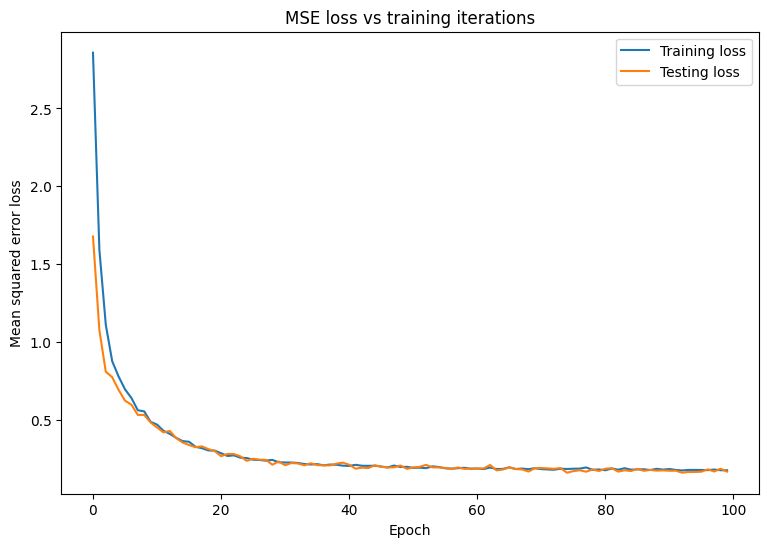

In [29]:
#绘制 MSE 损失随时间变化的图。计算指定验证集或测试集上的性能指标可确保模型不会对训练数据集过拟合，并且可以很好地泛化到未知数据。
matplotlib.rcParams['figure.figsize'] = [9, 6]

plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Mean squared error loss")
plt.legend()                                #看起来该模型在拟合训练数据方面做得很好，同时也良好地泛化了未知测试数据。
plt.title("MSE loss vs training iterations");

In [30]:
### 3.1.5 保存和加载模型
#首先，构建一个接受原始数据并执行以下运算的导出模块：
#   特征提取
#   归一化
#   预测
#   非归一化


class ExportModule(tf.Module):
  def __init__(self, model, extract_features, norm_x, norm_y):
    # Initialize pre and postprocessing functions
    self.model = model
    self.extract_features = extract_features
    self.norm_x = norm_x   #此处传入的是函数
    self.norm_y = norm_y

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.extract_features(x)
    x = self.norm_x.norm(x)
    y = self.model(x)
    y = self.norm_y.unnorm(y)
    return y


In [31]:
lin_reg_export = ExportModule(model=lin_reg,
                              extract_features=onehot_origin,
                              norm_x=norm_x,
                              norm_y=norm_y)

In [33]:
#如果要将模型保存为当前状态，请使用 tf.saved_model.save 函数。要加载保存的模型并进行预测，请使用 tf.saved_model.load 函数。
import tempfile
import os

models = tempfile.mkdtemp()
save_path = '__SavedModel/lin_reg_export' #os.path.join(models, '__SavedModel/lin_reg_export')
tf.saved_model.save(lin_reg_export, save_path)

INFO:tensorflow:Assets written to: __SavedModel/lin_reg_export\assets


INFO:tensorflow:Assets written to: __SavedModel/lin_reg_export\assets


In [34]:
lin_reg_loaded = tf.saved_model.load(save_path)
test_preds = lin_reg_loaded(x_test)
test_preds[:10].numpy()

array([28.058624, 26.163857, 33.58442 , 27.780079, 31.77824 , 24.081268,
       24.451231, 13.459925, 28.574219, 27.388735], dtype=float32)